## Is it a plate of Char Kway Teow or KL Hokkien Mee?

In [19]:
from IPython.display import display, HTML

html_code = """
<div style="display: flex;">
    <figure style="margin: 5px;">
        <img src="https://images.lifestyleasia.com/wp-content/uploads/sites/6/2023/01/27180753/best-char-kway-teow-singapore-hawker-stalls-heritage-local-food-hawker-centre.jpg?" width="400">
        <figcaption>Char Kway Teow</figcaption>
    </figure>
    <figure style="margin: 5px;">
        <img src="https://1.bp.blogspot.com/-JYKSvvSuJP8/X7hlGoQsEzI/AAAAAAABCfk/OPk0_qFpU5E9spa_p33sqgA0gNXyqCngACLcBGAsYHQ/s2048/KL%2BHokkien%2Bmee.jpg" width="400">
        <figcaption>KL Hokkien Mee</figcaption>
    </figure>
</div>
"""

display(HTML(html_code))

For the uninitiated, [**Char Kway Teow**](https://en.wikipedia.org/wiki/Char_kway_teow) ("CKT") and [**KL Hokkien Mee**](https://thewoksoflife.com/malaysian-hokkien-mee/#:~:text=What%20is%20%E2%80%9CKL%E2%80%9D%20Hokkien%20Mee,I%20would%20skip%20this%20recipe!) ("KLHM") are famous noodle dishes in their respective countries - CKT can be found primarily in Singapore, while there are several variants of Hokkien Mee found in Malaysia. I'm only interested in the variant found in Kuala Lumpur (KL).  
I've tasted them and they are both heavenly, although I'll attest that the latter is more sinful (more pork lard is used).  
They look similar (in my opinion) and I'm curious how well a Computer Vision model with some fine tuning can accurately discern CKT vs KLHM.  

This notebook is heavily inspired by Jeremy Howard's [kaggle notebook](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) and his amazing course - [Practical Deep Learning for Coders](https://course.fast.ai/Lessons/lesson1.html).

In [20]:
!pip install -Uqq fastai duckduckgo_search ipywidgets

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "singapore char kway teow photos"
2. Use DuckDuckGo to search for images of "malaysia KL hokkien mee photos"
3. Fine-tune a pretrained neural network to recognise these two groups
4. Try running this model on a plate of CKT and see if it works!
5. Analyze wrong predictions and clean up the data

## Step 1: Download images of CKT and KLHM

In [21]:
from duckduckgo_search import ddg_images
from fastcore.all import *


def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot("image")

Let's start by searching for a CKT photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [22]:
# NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images("singapore char kway teow", max_images=50)

Searching for 'singapore char kway teow'


c:\Users\choyd\OneDrive\Documents\projects\fastai_pdl1_getting_started\.venv\Lib\site-packages\duckduckgo_search\compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


...and then download a URL and take a look at it:

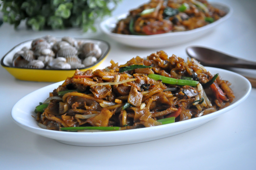

In [23]:
from fastdownload import download_url

dest = "ckt.jpg"
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *

im = Image.open(dest)
im.to_thumb(256, 256)

Now let's do the same with "malaysia KL hokkien mee photos":

Searching for 'malaysia KL hokkien mee'


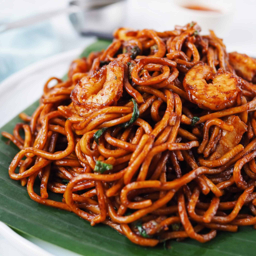

In [24]:
download_url(
    search_images("malaysia KL hokkien mee", max_images=1)[0],
    "msia_hkmee.jpg",
    show_progress=False,
)
Image.open("msia_hkmee.jpg").to_thumb(256, 256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of CKT and KLHM photos, and save each group of photos to a different folder (I'm also trying to grab overhead foodshots and pictures with chopsticks):

In [25]:
searches = "singapore char kway teow", "malaysia KL hokkien mee"
path = Path("ckt_or_not")

In [26]:
from time import sleep

for o in searches:
    dest = path / o
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f"{o} photo"))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f"{o} overhead photo"))
    sleep(10)
    download_images(dest, urls=search_images(f"{o} chopsticks photo"))
    sleep(10)
    resize_images(path / o, max_size=400, dest=path / o)

Searching for 'singapore char kway teow photo'
Searching for 'singapore char kway teow overhead photo'
Searching for 'singapore char kway teow chopsticks photo'
Searching for 'malaysia KL hokkien mee photo'
Searching for 'malaysia KL hokkien mee overhead photo'
Searching for 'malaysia KL hokkien mee chopsticks photo'


The dataset is not perfect. Some of the KLHM pictures are actually Penang Hokkien Mee or prawn noodles.  
In Lesson 2 of Practical Deep Learning for Coders 2022, Jeremy Howard actually posited to "train a model before cleaning the data" ([link with timestamp](https://youtu.be/F4tvM4Vb3A0?si=O1UUeqRU7K7vI2Md&t=765.)). Coming from a DS/ML background, this literally blew my mind since it's nearly always the other way around.  
I'll show you why it makes sense once the model has been trained and predictions has been made.

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [27]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

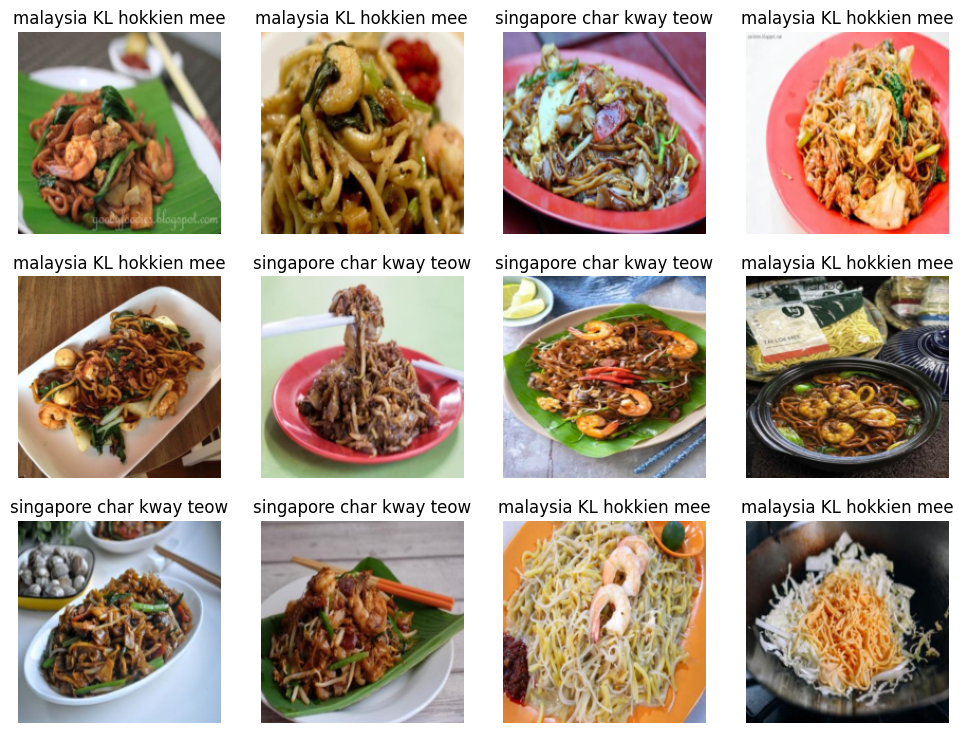

In [28]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method="squish")],
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "singapore char kway teow" or "malaysia KL hokkien mee").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *singapore char kway teow* or *malaysia KL hokkien mee*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. I found the best results with `resnet34`. More information on resnet34 can be found [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html).

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [29]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.009738,0.490208,0.241379,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.408837,0.254459,0.120690,00:05
1,0.276326,0.204493,0.068966,00:05
2,0.189620,0.164672,0.051724,00:05
3,0.140939,0.163262,0.086207,00:05
4,0.105843,0.160309,0.068966,00:05


"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

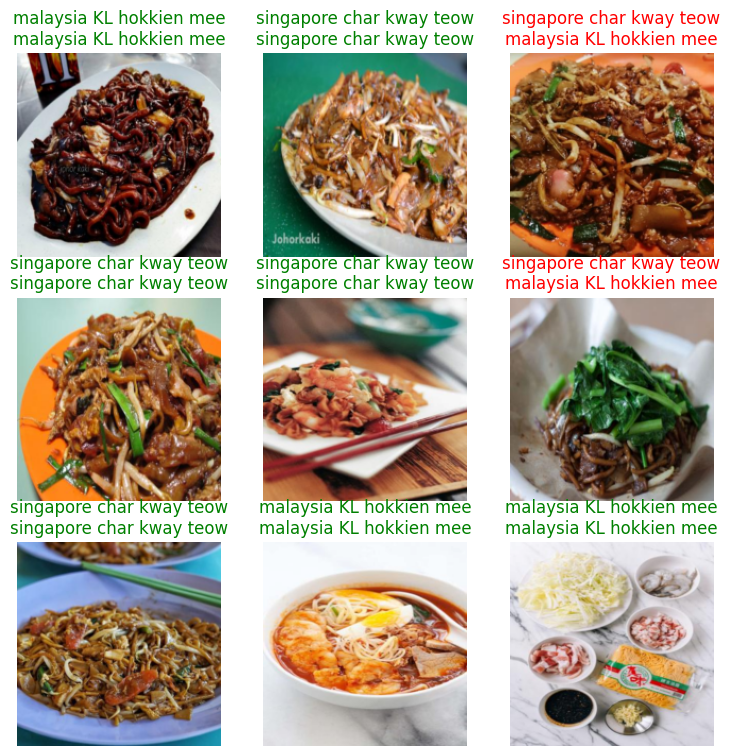

In [30]:
learn.show_results(max_n=9)

## Step 3: Use our model to make predictions

Let's see what our model thinks about that plate of CKT we downloaded at the start:

In [31]:
learn.predict(PILImage.create("ckt.jpg"))

('singapore char kway teow', tensor(1), tensor([2.5250e-04, 9.9975e-01]))

From the learner's `dls.vocab` attribute, I can see the model is predicting KLHM as 1 and CKT as 0.

In [32]:
learn.dls.vocab

['malaysia KL hokkien mee', 'singapore char kway teow']

In [33]:
is_ckt, _, probs = learn.predict(PILImage.create("ckt.jpg"))
print(f"This is {is_ckt}.")
print(f"Probability it's malaysia KL hokkien mee': {probs[0]:.4f}")

This is singapore char kway teow.
Probability it's malaysia KL hokkien mee': 0.0003


## Step 4: Analyzing model performance

Similar to ML classification tasks, a confusion matrix can be used to eyeball where CV classification predictions went wrong:

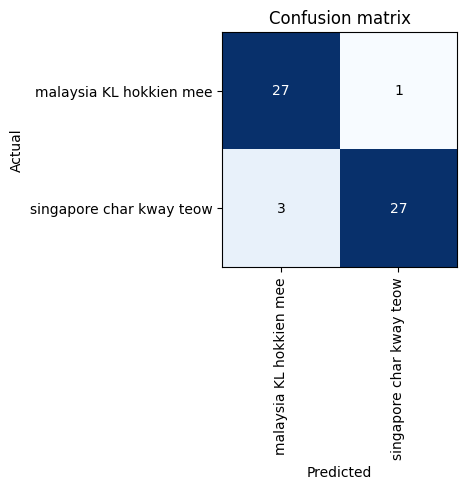

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Three cases of CKT were labelled wrongly, and one case of KLHM was labelled wrongly.  
It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't CKT/KLHM at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.).  
To do this, `plot_top_losses` is able to sort our images by their loss. Let's drill down into the top 6 results with the highest loss:

c:\Users\choyd\OneDrive\Documents\projects\fastai_pdl1_getting_started\.venv\Lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


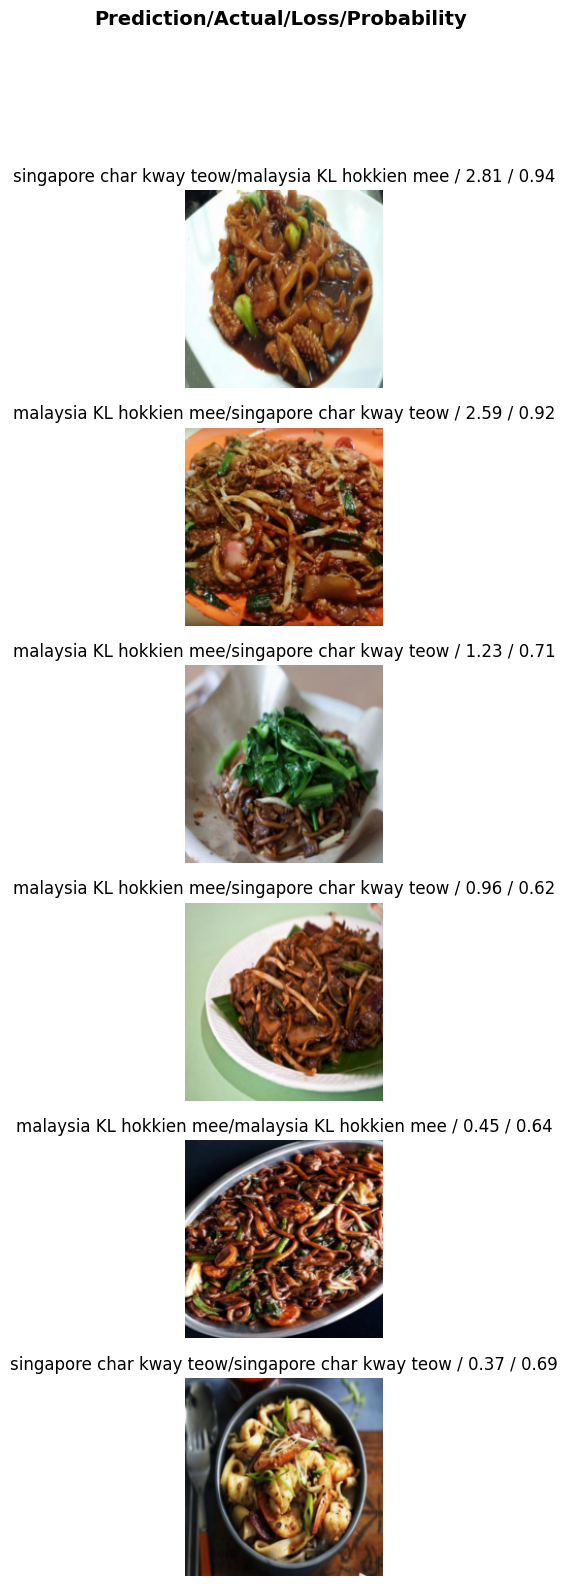

In [35]:
interp.plot_top_losses(6, nrows=6)

Some thoughts: 
- The vegetables in the first image probably threw the model off (KLHM is rarely served with greens)
- The last image doesn't seem to be either CKT or KLHM


## Step 5: Cleaning the data

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [36]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

By training the model first, a large part of the data cleaning has been automated by focusing on the predictions with the highest loss.  
The next reasonable steps would then be to manually address these predictions by removing or re-labelling them if necessary, then fine-tune the model once more on a cleaner dataset which should result in a lower validation loss.